In [27]:
# Install DGL 
!pip install dgl==0.6.1

In [28]:
pip install pytorch-ignite

In [29]:
# Import libs
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from ignite.engine import Engine
from ignite.metrics import ConfusionMatrix, Accuracy, Loss
from ignite.engine import create_supervised_evaluator

from sklearn.model_selection import KFold

import dgl
from dgl import DGLGraph
from dgl.data import MiniGCDataset

import time

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline 

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Collate function to prepare graphs

In [83]:
# collate function 
def collate(samples):
    graphs, labels = map(list, zip(*samples)) # samples is a list of pairs (graph, label).
    labels = torch.tensor(labels)
    tab_sizes_n = [ graphs[i].number_of_nodes() for i in range(len(graphs))] # graph sizes
    tab_snorm_n = [ torch.FloatTensor(size,1).fill_(1./float(size)) for size in tab_sizes_n ]
    snorm_n = torch.cat(tab_snorm_n).sqrt() # graph size normalization 
    tab_sizes_e = [ graphs[i].number_of_edges() for i in range(len(graphs))] # nb of edges
    tab_snorm_e = [ torch.FloatTensor(size,1).fill_(1./float(size)) for size in tab_sizes_e ]
    snorm_e = torch.cat(tab_snorm_e).sqrt() # graph size normalization
    batched_graph = dgl.batch(graphs) # batch graphs
    return batched_graph, labels, snorm_n, snorm_e

# create artifical data feature (= in degree) for each node
def create_artificial_features(dataset):
    for (graph,_) in dataset:
        graph.ndata['feat'] = graph.in_degrees().view(-1, 1).float()
        graph.edata['feat'] = torch.ones(graph.number_of_edges(),1)
    return dataset

# If evaluating will be k-fold cross validation, set graph number to 1000
trainset = MiniGCDataset(1000, 10, 20)
trainset = create_artificial_features(trainset)

# For k-fold cross validation evaluate
k_folds = 10
kfold = KFold(n_splits=k_folds, shuffle=True)
# K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(trainset)):
    
    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')
    
    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

# For other method
"""# generate artifical graph dataset with DGL

testset = MiniGCDataset(100, 10, 20)
valset = MiniGCDataset(100, 10, 20)

testset = create_artificial_features(testset)
valset = create_artificial_features(valset)

for i in range (900):
  print(trainset[i])"""


FOLD 0
--------------------------------
FOLD 1
--------------------------------
FOLD 2
--------------------------------
FOLD 3
--------------------------------
FOLD 4
--------------------------------
FOLD 5
--------------------------------
FOLD 6
--------------------------------
FOLD 7
--------------------------------
FOLD 8
--------------------------------
FOLD 9
--------------------------------


'# generate artifical graph dataset with DGL\n\ntestset = MiniGCDataset(100, 10, 20)\nvalset = MiniGCDataset(100, 10, 20)\n\ntestset = create_artificial_features(testset)\nvalset = create_artificial_features(valset)\n\nfor i in range (900):\n  print(trainset[i])'

# Visualize graph dataset

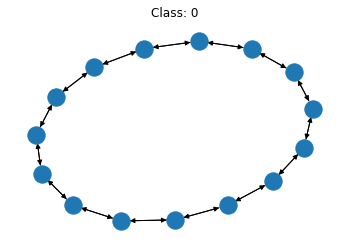

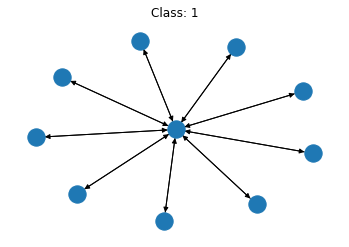

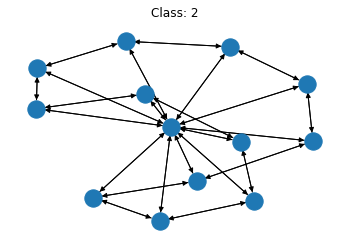

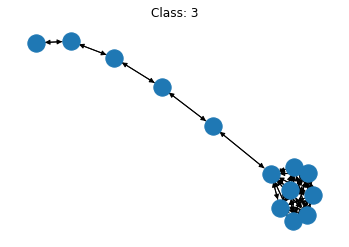

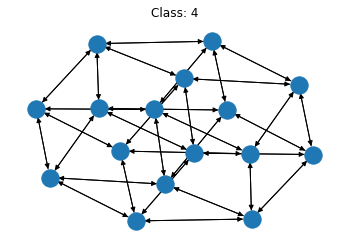

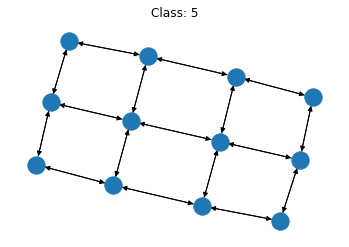

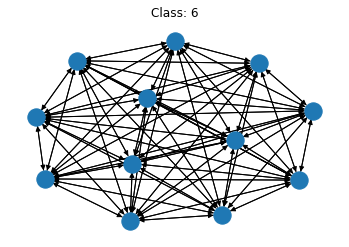

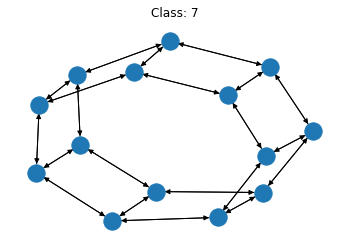

In [84]:
visualset = MiniGCDataset(8, 10, 20)

# visualise the 8 classes of graphs
for c in range(8):
    graph, label = visualset[c] 
    fig, ax = plt.subplots()
    nx.draw(graph.to_networkx(), ax=ax)
    ax.set_title('Class: {:d}'.format(label))
    plt.show()

# Implement GatedGCNs with DGL

\begin{eqnarray}
h_i^{\ell+1} &=& h_i^{\ell} + \text{ReLU} \left( A^\ell h_i^{\ell} +  \sum_{j\sim i} \eta(e_{ij}^{\ell}) \odot B^\ell h_j^{\ell} \right), \quad \eta(e_{ij}^{\ell}) = \frac{\sigma(e_{ij}^{\ell})}{\sum_{j'\sim i} \sigma(e_{ij'}^{\ell}) + \varepsilon} \\
e_{ij}^{\ell+1} &=& e^\ell_{ij} + \text{ReLU} \Big( C^\ell e_{ij}^{\ell} + D^\ell h^{\ell+1}_i + E^\ell h^{\ell+1}_j  \Big)
\end{eqnarray}


In [85]:
class MLP_layer(nn.Module):
    def __init__(self, input_dim, output_dim, L=2): # L = nb of hidden layers
        super(MLP_layer, self).__init__()
        list_FC_layers = [ nn.Linear( input_dim, input_dim, bias=True ) for l in range(L) ]
        list_FC_layers.append(nn.Linear( input_dim, output_dim , bias=True ))
        self.FC_layers = nn.ModuleList(list_FC_layers)
        self.L = L
        
    def forward(self, x):
        y = x
        for l in range(self.L):
            y = self.FC_layers[l](y)
            y = torch.relu(y)
        y = self.FC_layers[self.L](y)
        return y

In [86]:
class GatedGCN_layer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(GatedGCN_layer, self).__init__()
        self.A = nn.Linear(input_dim, output_dim, bias=True)
        self.B = nn.Linear(input_dim, output_dim, bias=True)
        self.C = nn.Linear(input_dim, output_dim, bias=True)
        self.D = nn.Linear(input_dim, output_dim, bias=True)
        self.E = nn.Linear(input_dim, output_dim, bias=True)
        self.bn_node_h = nn.BatchNorm1d(output_dim)
        self.bn_node_e = nn.BatchNorm1d(output_dim)

    def message_func(self, edges):
        Bh_j = edges.src['Bh'] 
        e_ij = edges.data['Ce'] +  edges.src['Dh'] + edges.dst['Eh'] # e_ij = Ce_ij + Dhi + Ehj
        edges.data['e'] = e_ij
        return {'Bh_j' : Bh_j, 'e_ij' : e_ij}

    def reduce_func(self, nodes):
        Ah_i = nodes.data['Ah']
        Bh_j = nodes.mailbox['Bh_j']
        e = nodes.mailbox['e_ij'] 
        sigma_ij = torch.sigmoid(e) # sigma_ij = sigmoid(e_ij)
        h = Ah_i + torch.sum( sigma_ij * Bh_j, dim=1 ) / torch.sum( sigma_ij, dim=1 )  # hi = Ahi + sum_j eta_ij * Bhj    
        return {'h' : h}
    
    def forward(self, g, h, e, snorm_n, snorm_e):
        h_in = h # residual connection
        e_in = e # residual connection
        
        g.ndata['h']  = h 
        g.ndata['Ah'] = self.A(h) 
        g.ndata['Bh'] = self.B(h) 
        g.ndata['Dh'] = self.D(h)
        g.ndata['Eh'] = self.E(h) 
        g.edata['e']  = e 
        g.edata['Ce'] = self.C(e) 
        g.update_all(self.message_func,self.reduce_func) 
        h = g.ndata['h'] # result of graph convolution
        e = g.edata['e'] # result of graph convolution
        
        h = h* snorm_n # normalize activation w.r.t. graph node size
        e = e* snorm_e # normalize activation w.r.t. graph edge size
        
        h = self.bn_node_h(h) # batch normalization  
        e = self.bn_node_e(e) # batch normalization  
        
        h = torch.relu(h) # non-linear activation
        e = torch.relu(e) # non-linear activation
        
        h = h_in + h # residual connection
        e = e_in + e # residual connection
        
        return h, e

In [88]:
class GatedGCN_Net(nn.Module):
    
    def __init__(self, net_parameters):
        super(GatedGCN_Net, self).__init__()
        input_dim = net_parameters['input_dim']
        hidden_dim = net_parameters['hidden_dim']
        output_dim = net_parameters['output_dim']
        L = net_parameters['L']
        self.embedding_h = nn.Linear(input_dim, hidden_dim)
        self.embedding_e = nn.Linear(1, hidden_dim)
        self.GatedGCN_layers = nn.ModuleList([ GatedGCN_layer(hidden_dim, hidden_dim) for _ in range(L) ]) 
        self.MLP_layer = MLP_layer(hidden_dim, output_dim)
        
    def forward(self, g, h, e, snorm_n, snorm_e):
        
        # input embedding
        h = self.embedding_h(h)
        e = self.embedding_e(e)
        
        # graph convnet layers
        for GGCN_layer in self.GatedGCN_layers:
            h,e = GGCN_layer(g,h,e,snorm_n,snorm_e)
        
        # MLP classifier
        g.ndata['h'] = h
        y = dgl.mean_nodes(g,'h')
        y = self.MLP_layer(y)
        
        return y    
    
    def loss(self, y_scores, y_labels):
        loss = nn.CrossEntropyLoss()(y_scores, y_labels)
        return loss        
        
    def accuracy(self, scores, targets):
        scores = scores.detach().argmax(dim=1)
        acc = (scores==targets).float().sum().item()
        return acc
    
    def update(self, lr):       
        update = torch.optim.Adam( self.parameters(), lr=lr )
        return update

    """def binary_one_hot_output_transform(self, output):
        y_pred, y = output
        y_pred = torch.sigmoid(y_pred).round().long()
        y_pred = ignite.utils.to_onehot(y_pred, 2)
        y = y.long()
        return y_pred, y"""

In [89]:
# network parameters
net_parameters = {}
net_parameters['input_dim'] = 1
net_parameters['hidden_dim'] = 200
net_parameters['output_dim'] = 8 # nb of classes
net_parameters['L'] = 2

# instantiate network
net = GatedGCN_Net(net_parameters)
print(net)

GatedGCN_Net(
  (embedding_h): Linear(in_features=1, out_features=200, bias=True)
  (embedding_e): Linear(in_features=1, out_features=200, bias=True)
  (GatedGCN_layers): ModuleList(
    (0): GatedGCN_layer(
      (A): Linear(in_features=200, out_features=200, bias=True)
      (B): Linear(in_features=200, out_features=200, bias=True)
      (C): Linear(in_features=200, out_features=200, bias=True)
      (D): Linear(in_features=200, out_features=200, bias=True)
      (E): Linear(in_features=200, out_features=200, bias=True)
      (bn_node_h): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn_node_e): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): GatedGCN_layer(
      (A): Linear(in_features=200, out_features=200, bias=True)
      (B): Linear(in_features=200, out_features=200, bias=True)
      (C): Linear(in_features=200, out_features=200, bias=True)
      (D): Linear(in_features=200, out_features=2

# Test forward pass

In [90]:
train_loader = DataLoader(trainset, batch_size=10, shuffle=True, collate_fn=collate)

# For k-fold cross validation evaluate
#train_loader = torch.utils.data.DataLoader(trainset, batch_size=10, sampler=train_subsampler, collate_fn=collate)

batch_graphs, batch_labels, batch_snorm_n, batch_snorm_e = list(train_loader)[0]
print(batch_graphs)
print(batch_labels)
print(batch_snorm_n.size())
print(batch_snorm_e.size())

batch_x = batch_graphs.ndata['feat']
print('batch_x',batch_x.size())

batch_e = batch_graphs.edata['feat']
print('batch_e',batch_e.size())

batch_snorm_n = batch_snorm_n
print('batch_snorm_n',batch_snorm_n.size())

batch_snorm_e = batch_snorm_e
print('batch_snorm_e',batch_snorm_e.size())

batch_scores = net.forward(batch_graphs, batch_x, batch_e, batch_snorm_n, batch_snorm_e)
print(batch_scores.size())

batch_labels = batch_labels
accuracy = net.accuracy(batch_scores,batch_labels)
print(accuracy)

Graph(num_nodes=132, num_edges=776,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)})
tensor([4, 0, 3, 2, 1, 4, 2, 2, 7, 6])
torch.Size([132, 1])
torch.Size([776, 1])
batch_x torch.Size([132, 1])
batch_e torch.Size([776, 1])
batch_snorm_n torch.Size([132, 1])
batch_snorm_e torch.Size([776, 1])
torch.Size([10, 8])
0.0


# Test backward pass

In [91]:
# optimization parameters
opt_parameters = {}
opt_parameters['lr'] = 0.0005

# Loss
loss = net.loss(batch_scores, batch_labels.long())

# Backward pass
lr = opt_parameters['lr']
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
optimizer.zero_grad()
loss.backward()
optimizer.step()

# Train one epoch

In [92]:
def train_one_epoch(net, data_loader):
    net.train()
    epoch_loss = 0
    epoch_train_acc = 0
    nb_data = 0
    gpu_mem = 0
    for iter, (batch_graphs, batch_labels, batch_snorm_n, batch_snorm_e) in enumerate(data_loader):
        batch_x = batch_graphs.ndata['feat']
        batch_e = batch_graphs.edata['feat']
        batch_snorm_n = batch_snorm_n
        batch_snorm_e = batch_snorm_e
        batch_labels = batch_labels
        batch_scores = net.forward(batch_graphs, batch_x, batch_e, batch_snorm_n, batch_snorm_e)
        loss = net.loss(batch_scores, batch_labels.long())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
        epoch_train_acc += net.accuracy(batch_scores,batch_labels)
        nb_data += batch_labels.size(0)
    epoch_loss /= (iter + 1)
    epoch_train_acc /= nb_data
    return epoch_loss, epoch_train_acc  

# Evaluation

In [95]:
def evaluate_network(net, data_loader):
    "evaluate test set"
    net.eval()
    epoch_test_loss = 0
    epoch_test_acc = 0
    nb_data = 0
    with torch.no_grad():
        for iter, (batch_graphs, batch_labels, batch_snorm_n, batch_snorm_e) in enumerate(data_loader):
            batch_x = batch_graphs.ndata['feat']
            batch_e = batch_graphs.edata['feat']
            batch_snorm_n = batch_snorm_n
            batch_snorm_e = batch_snorm_e
            batch_labels = batch_labels
            batch_scores = net.forward(batch_graphs, batch_x, batch_e, batch_snorm_n, batch_snorm_e)
            loss = net.loss(batch_scores, batch_labels.long())
            epoch_test_loss += loss.detach().item()
            epoch_test_acc += net.accuracy(batch_scores,batch_labels)
            nb_data += batch_labels.size(0)
        epoch_test_loss /= (iter + 1)
        epoch_test_acc /= nb_data

    return epoch_test_loss, epoch_test_acc

""" metrics = {
    "confusion_matrix": ConfusionMatrix(2, output_transform=net.binary_one_hot_output_transform),
}

evaluator = create_supervised_evaluator(
    net, metrics=metrics, output_transform=lambda x, y, y_pred: (y_pred, y)
) """

' metrics = {\n    "confusion_matrix": ConfusionMatrix(2, output_transform=net.binary_one_hot_output_transform),\n}\n\nevaluator = create_supervised_evaluator(\n    net, metrics=metrics, output_transform=lambda x, y, y_pred: (y_pred, y)\n) '

# Train GNN

In [96]:
# For other method
# datasets
#train_loader = DataLoader(trainset, batch_size=100, shuffle=True, collate_fn=collate)
#test_loader = DataLoader(testset, batch_size=100, shuffle=False, collate_fn=collate)
#val_loader = DataLoader(valset, batch_size=100, shuffle=False, drop_last=False, collate_fn=collate)
 
# Define data loaders for training and testing data in this fold
# For k-fold cross validation evaluate
train_loader = torch.utils.data.DataLoader(trainset, batch_size=200, sampler=train_subsampler, collate_fn=collate)
test_loader = torch.utils.data.DataLoader(trainset,batch_size=200, sampler=test_subsampler, collate_fn=collate)

# Create model
net_parameters = {}
net_parameters['input_dim'] = 1
net_parameters['hidden_dim'] = 200
net_parameters['output_dim'] = 8 # nb of classes
net_parameters['L'] = 4
net = GatedGCN_Net(net_parameters)

optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

epoch_train_losses = []
epoch_test_losses = []
epoch_val_losses = []
epoch_train_accs = []
epoch_test_accs = []
epoch_val_accs = []

for epoch in range(40):
    start = time.time()
    epoch_train_loss, epoch_train_acc = train_one_epoch(net, train_loader)
    epoch_test_loss, epoch_test_acc = evaluate_network(net, test_loader)
    epoch_val_loss, epoch_val_acc = evaluate_network(net, val_loader)

    # For other method
    #print('Epoch {}, time {:.4f}, train_loss: {:.4f}, test_loss: {:.4f}, val_loss: {:.4f} \n train_acc: {:.4f}, test_acc: {:.4f}, val_acc: {:.4f}'.format(epoch, time.time()-start, epoch_train_loss, epoch_test_loss, epoch_val_loss, epoch_train_acc, epoch_test_acc, epoch_val_acc))
     
    # For k-fold cross validation evaluate
    print('Epoch {}, time {:.4f}, train_loss: {:.4f}, test_loss: {:.4f} \n train_acc: {:.4f}, test_acc: {:.4f}'.format(epoch, time.time()-start, epoch_train_loss, epoch_test_loss, epoch_train_acc, epoch_test_acc))

Epoch 0, time 12.1522, train_loss: 1.8866, test_loss: 1.9682 
 train_acc: 0.2367, test_acc: 0.1200
Epoch 1, time 12.1785, train_loss: 1.6714, test_loss: 1.8962 
 train_acc: 0.3556, test_acc: 0.1900
Epoch 2, time 12.2504, train_loss: 1.5316, test_loss: 1.8082 
 train_acc: 0.3989, test_acc: 0.2100
Epoch 3, time 12.1913, train_loss: 1.4008, test_loss: 1.6966 
 train_acc: 0.5811, test_acc: 0.2400
Epoch 4, time 12.2355, train_loss: 1.2973, test_loss: 1.5597 
 train_acc: 0.6711, test_acc: 0.4600
Epoch 5, time 12.1961, train_loss: 1.1781, test_loss: 1.4110 
 train_acc: 0.7111, test_acc: 0.5500
Epoch 6, time 12.0981, train_loss: 1.0792, test_loss: 1.2613 
 train_acc: 0.7400, test_acc: 0.8000
Epoch 7, time 12.1997, train_loss: 0.9752, test_loss: 1.1317 
 train_acc: 0.7889, test_acc: 0.7700
Epoch 8, time 12.1443, train_loss: 0.8955, test_loss: 1.0185 
 train_acc: 0.7889, test_acc: 0.7800
Epoch 9, time 12.2200, train_loss: 0.8131, test_loss: 0.9132 
 train_acc: 0.8133, test_acc: 0.7800
Epoch 10, 